In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold

In [2]:
data = pd.read_csv('../input/football-hackathon/train_1K0BDt5/train.csv')
test = pd.read_csv('../input/football-hackathon/test_kuhCxHY/test.csv')
sub  = pd.read_csv('../input/football-hackathon/sample_submission_wBWLI0s.csv')

In [3]:
winner = {'winner': 1, 'loser': -1, 'draw': 0}

data['winner'] = data['winner'].map(winner)
test['winner'] = test['winner'].map(winner)

data['team'] = data['team'].map({'team1' : 0, 'team2' : 1})
test['team'] = test['team'].map({'team1' : 0, 'team2' : 1})

data = pd.get_dummies(data, columns = ['competitionId', 'scout_id','team1_system_id', 'team2_system_id', 'player_position_1','player_position_2'])
test = pd.get_dummies(test, columns = ['competitionId', 'scout_id','team1_system_id', 'team2_system_id', 'player_position_1','player_position_2'])

del data['row_id'], test['row_id']

In [4]:
cols = list(set(test.columns.to_list()).intersection(set(data.columns.to_list())))

lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mean_squared_error',
    'num_iterations' : 10000,
    'learning_rate' : 0.2,
    'nthread':-1,
    'seed' : 16,
}


remove_cols = []
for col in cols:
    
    if data[col].isna().sum() > 15000: remove_cols.append(col)
        
for col in remove_cols :
    cols.remove(col)
    
print(len(cols))

843


In [5]:
N_folds = 5
seeds = [16, 6, 7]

data_preds = np.zeros((data.shape[0]))
test_preds = np.zeros((test.shape[0]))

feature_importance = pd.DataFrame()
fold_scores = []

for seed in seeds:
    print('---------------------------------------')
    print('SEED : ', seed)
    print('---------------------------------------')
    
    
    data['fold'] = -1
    skf = StratifiedKFold(n_splits=N_folds, shuffle=True, random_state=seed)
    for f, (_, idxs) in enumerate(skf.split(data,data['rating_num'].apply(lambda x: int(2*x)))):
        data.loc[idxs, 'fold'] = f
        
    for F in range(N_folds):
        
        print('FOLD : ', F)
        
        train = data[data['fold'] != F].reset_index(drop=True)
        valid = data[data['fold'] == F].reset_index(drop=True)
        
        
        train_dataset = lgb.Dataset(train[cols], train['rating_num'])
        valid_dataset = lgb.Dataset(valid[cols], valid['rating_num'])
        
        model = lgb.train(params = lgb_params,
                          num_boost_round=5000,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, valid_dataset], 
                          verbose_eval = 50,
                          early_stopping_rounds=50)
        
        del train_dataset, valid_dataset
        
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = cols
        fold_importance["importance"] = model.feature_importance()
        fold_importance["fold"] = F + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
        
        
        preds = model.predict(valid[cols])
        data_preds[data[data['fold'] == F].index] += preds
        
        fold_scores.append(r2_score(valid['rating_num'], preds))
        
        preds = model.predict(test[cols])
        test_preds += preds

---------------------------------------
SEED :  16
---------------------------------------
FOLD :  0


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92683
[LightGBM] [Info] Number of data points in the train set: 16362, number of used features: 831
[LightGBM] [Info] Start training from score 6.887269
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 1.51025	valid_1's l2: 2.46428
[100]	training's l2: 0.96905	valid_1's l2: 2.35671
[150]	training's l2: 0.642826	valid_1's l2: 2.31436
[200]	training's l2: 0.435751	valid_1's l2: 2.28671
[250]	training's l2: 0.302112	valid_1's l2: 2.26935
[300]	training's l2: 0.211794	valid_1's l2: 2.25508
[350]	training's l2: 0.153157	valid_1's l2: 2.24116
[400]	training's l2: 0.110695	valid_1's l2: 2.22849
[450]	training's l2: 0.0801588	valid_1's l2: 2.21712
[500]	training's l2: 0.0596981	valid_1's l2: 2.20908
[550]	training's l2: 0.0450793	valid_1's l2: 2.20764
[600]	training's l2:

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92707
[LightGBM] [Info] Number of data points in the train set: 16362, number of used features: 830
[LightGBM] [Info] Start training from score 6.887392
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 1.51947	valid_1's l2: 2.49035
[100]	training's l2: 0.976973	valid_1's l2: 2.38167
[150]	training's l2: 0.651211	valid_1's l2: 2.33358
[200]	training's l2: 0.452677	valid_1's l2: 2.2944
[250]	training's l2: 0.313147	valid_1's l2: 2.25936
[300]	training's l2: 0.220909	valid_1's l2: 2.24106
[350]	training's l2: 0.156768	valid_1's l2: 2.22405
[400]	training's l2: 0.114265	valid_1's l2: 2.21564
[450]	training's l2: 0.0831919	valid_1's l2: 2.20744
[500]	training's l2: 0.0609212	valid_1's l2: 2.19471
[550]	training's l2: 0.0449273	valid_1's l2: 2.19263
[600]	training's l2:

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92764
[LightGBM] [Info] Number of data points in the train set: 16362, number of used features: 831
[LightGBM] [Info] Start training from score 6.887605
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 1.50616	valid_1's l2: 2.54723
[100]	training's l2: 0.970663	valid_1's l2: 2.43297
[150]	training's l2: 0.66006	valid_1's l2: 2.39654
[200]	training's l2: 0.450968	valid_1's l2: 2.3538
[250]	training's l2: 0.316397	valid_1's l2: 2.34384
[300]	training's l2: 0.222513	valid_1's l2: 2.32894
[350]	training's l2: 0.160383	valid_1's l2: 2.31655
[400]	training's l2: 0.115102	valid_1's l2: 2.3105
[450]	training's l2: 0.0829226	valid_1's l2: 2.30288
[500]	training's l2: 0.0612522	valid_1's l2: 2.29738
[550]	training's l2: 0.0452205	valid_1's l2: 2.29126
[600]	training's l2: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.196052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92794
[LightGBM] [Info] Number of data points in the train set: 16363, number of used features: 830
[LightGBM] [Info] Start training from score 6.887368
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 1.52815	valid_1's l2: 2.36788
[100]	training's l2: 0.972858	valid_1's l2: 2.23083
[150]	training's l2: 0.65802	valid_1's l2: 2.16613
[200]	training's l2: 0.455258	valid_1's l2: 2.13382
[250]	training's l2: 0.318257	valid_1's l2: 2.11181
[300]	training's l2: 0.223163	valid_1's l2: 2.0924
[350]	training's l2: 0.159911	valid_1's l2: 2.07974
[400]	training's l2: 0.114887	valid_1's l2: 2.07413
[450]	training's l2: 0.082287	valid_1's l2: 2.07064
[500]	training's l2: 0.0597196	valid_1's l2: 2.06668
[550]	training's l2: 0.0441276	valid_1's l2: 2.0654
[600]	training's l2: 0.

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.262901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92743
[LightGBM] [Info] Number of data points in the train set: 16363, number of used features: 830
[LightGBM] [Info] Start training from score 6.886879
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 1.50502	valid_1's l2: 2.45588
[100]	training's l2: 0.981955	valid_1's l2: 2.36662
[150]	training's l2: 0.660816	valid_1's l2: 2.31032
[200]	training's l2: 0.447849	valid_1's l2: 2.2651
[250]	training's l2: 0.313717	valid_1's l2: 2.23747
[300]	training's l2: 0.220803	valid_1's l2: 2.2275
[350]	training's l2: 0.158236	valid_1's l2: 2.21769
[400]	training's l2: 0.11454	valid_1's l2: 2.20976
[450]	training's l2: 0.0834912	valid_1's l2: 2.20126
[500]	training's l2: 0.0625117	valid_1's l2: 2.18941
[550]	training's l2: 0.0467125	valid_1's l2: 2.18624
[600]	training's l2: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92715
[LightGBM] [Info] Number of data points in the train set: 16362, number of used features: 830
[LightGBM] [Info] Start training from score 6.887269
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 1.50639	valid_1's l2: 2.46219
[100]	training's l2: 0.955706	valid_1's l2: 2.37088
[150]	training's l2: 0.652464	valid_1's l2: 2.32298
[200]	training's l2: 0.447318	valid_1's l2: 2.28698
[250]	training's l2: 0.311515	valid_1's l2: 2.26091
[300]	training's l2: 0.216406	valid_1's l2: 2.24917
[350]	training's l2: 0.154883	valid_1's l2: 2.23194
[400]	training's l2: 0.11023	valid_1's l2: 2.22266
[450]	training's l2: 0.0814573	valid_1's l2: 2.21526
[500]	training's l2: 0.0603024	valid_1's l2: 2.21165
[550]	training's l2: 0.0446403	valid_1's l2: 2.20832
[600]	training's l2:

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92770
[LightGBM] [Info] Number of data points in the train set: 16362, number of used features: 831
[LightGBM] [Info] Start training from score 6.887392
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 1.52638	valid_1's l2: 2.40325
[100]	training's l2: 0.966941	valid_1's l2: 2.30372
[150]	training's l2: 0.654317	valid_1's l2: 2.26374
[200]	training's l2: 0.443758	valid_1's l2: 2.24431
[250]	training's l2: 0.311746	valid_1's l2: 2.229
[300]	training's l2: 0.219652	valid_1's l2: 2.21047
[350]	training's l2: 0.156402	valid_1's l2: 2.20261
[400]	training's l2: 0.111728	valid_1's l2: 2.19829
[450]	training's l2: 0.0799962	valid_1's l2: 2.18797
[500]	training's l2: 0.0582522	valid_1's l2: 2.18156
[550]	training's l2: 0.0436862	valid_1's l2: 2.17742
[600]	training's l2: 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92819
[LightGBM] [Info] Number of data points in the train set: 16362, number of used features: 831
[LightGBM] [Info] Start training from score 6.887605
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 1.52069	valid_1's l2: 2.50265
[100]	training's l2: 0.976531	valid_1's l2: 2.39778
[150]	training's l2: 0.660604	valid_1's l2: 2.33447
[200]	training's l2: 0.458587	valid_1's l2: 2.28874
[250]	training's l2: 0.321808	valid_1's l2: 2.25049
[300]	training's l2: 0.224214	valid_1's l2: 2.22287
[350]	training's l2: 0.162084	valid_1's l2: 2.20259
[400]	training's l2: 0.116302	valid_1's l2: 2.19937
[450]	training's l2: 0.085396	valid_1's l2: 2.19113
[500]	training's l2: 0.0633273	valid_1's l2: 2.18827
[550]	training's l2: 0.0465593	valid_1's l2: 2.18571
[600]	training's l2:

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92696
[LightGBM] [Info] Number of data points in the train set: 16363, number of used features: 831
[LightGBM] [Info] Start training from score 6.887368
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 1.49613	valid_1's l2: 2.46558
[100]	training's l2: 0.961331	valid_1's l2: 2.37809
[150]	training's l2: 0.641262	valid_1's l2: 2.32753
[200]	training's l2: 0.438887	valid_1's l2: 2.30295
[250]	training's l2: 0.306704	valid_1's l2: 2.28309
[300]	training's l2: 0.217354	valid_1's l2: 2.27359
[350]	training's l2: 0.153924	valid_1's l2: 2.26184
[400]	training's l2: 0.111202	valid_1's l2: 2.24832
[450]	training's l2: 0.0801587	valid_1's l2: 2.23101
[500]	training's l2: 0.0592639	valid_1's l2: 2.22242
[550]	training's l2: 0.0438564	valid_1's l2: 2.21262
[600]	training's l2

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92749
[LightGBM] [Info] Number of data points in the train set: 16363, number of used features: 831
[LightGBM] [Info] Start training from score 6.886879
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 1.50499	valid_1's l2: 2.43508
[100]	training's l2: 0.970319	valid_1's l2: 2.32868
[150]	training's l2: 0.650711	valid_1's l2: 2.28205
[200]	training's l2: 0.448725	valid_1's l2: 2.2477
[250]	training's l2: 0.311312	valid_1's l2: 2.22871
[300]	training's l2: 0.219628	valid_1's l2: 2.20627
[350]	training's l2: 0.156813	valid_1's l2: 2.1929
[400]	training's l2: 0.112156	valid_1's l2: 2.18849
[450]	training's l2: 0.0808967	valid_1's l2: 2.17319
[500]	training's l2: 0.0592013	valid_1's l2: 2.16727
[550]	training's l2: 0.0446859	valid_1's l2: 2.16046
[600]	training's l2: 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92681
[LightGBM] [Info] Number of data points in the train set: 16362, number of used features: 830
[LightGBM] [Info] Start training from score 6.887269
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 1.51097	valid_1's l2: 2.45406
[100]	training's l2: 0.970249	valid_1's l2: 2.33553
[150]	training's l2: 0.660277	valid_1's l2: 2.28382
[200]	training's l2: 0.453814	valid_1's l2: 2.25638
[250]	training's l2: 0.314799	valid_1's l2: 2.23997
[300]	training's l2: 0.223716	valid_1's l2: 2.21642
[350]	training's l2: 0.159872	valid_1's l2: 2.20697
[400]	training's l2: 0.114877	valid_1's l2: 2.1986
[450]	training's l2: 0.0833523	valid_1's l2: 2.18545
[500]	training's l2: 0.0619032	valid_1's l2: 2.18156
[550]	training's l2: 0.0457766	valid_1's l2: 2.17299
[600]	training's l2:

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92726
[LightGBM] [Info] Number of data points in the train set: 16362, number of used features: 832
[LightGBM] [Info] Start training from score 6.887392
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 1.50577	valid_1's l2: 2.44596
[100]	training's l2: 0.955081	valid_1's l2: 2.33616
[150]	training's l2: 0.641616	valid_1's l2: 2.29261
[200]	training's l2: 0.436842	valid_1's l2: 2.25778
[250]	training's l2: 0.307008	valid_1's l2: 2.22601
[300]	training's l2: 0.21992	valid_1's l2: 2.20311
[350]	training's l2: 0.157008	valid_1's l2: 2.18513
[400]	training's l2: 0.112119	valid_1's l2: 2.18042
[450]	training's l2: 0.0827047	valid_1's l2: 2.17484
[500]	training's l2: 0.060793	valid_1's l2: 2.17054
[550]	training's l2: 0.0458908	valid_1's l2: 2.1669
[600]	training's l2: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92732
[LightGBM] [Info] Number of data points in the train set: 16362, number of used features: 830
[LightGBM] [Info] Start training from score 6.887605
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 1.53103	valid_1's l2: 2.44663
[100]	training's l2: 0.985389	valid_1's l2: 2.33752
[150]	training's l2: 0.65752	valid_1's l2: 2.29476
[200]	training's l2: 0.456418	valid_1's l2: 2.27033
[250]	training's l2: 0.319024	valid_1's l2: 2.2394
[300]	training's l2: 0.227356	valid_1's l2: 2.22081
[350]	training's l2: 0.159839	valid_1's l2: 2.20831
[400]	training's l2: 0.115745	valid_1's l2: 2.19171
[450]	training's l2: 0.0834307	valid_1's l2: 2.1806
[500]	training's l2: 0.0605904	valid_1's l2: 2.16987
[550]	training's l2: 0.0448132	valid_1's l2: 2.16363
[600]	training's l2: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92791
[LightGBM] [Info] Number of data points in the train set: 16363, number of used features: 831
[LightGBM] [Info] Start training from score 6.887368
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 1.51127	valid_1's l2: 2.47348
[100]	training's l2: 0.945848	valid_1's l2: 2.38677
[150]	training's l2: 0.644664	valid_1's l2: 2.34094
[200]	training's l2: 0.445829	valid_1's l2: 2.30557
[250]	training's l2: 0.30905	valid_1's l2: 2.28453
[300]	training's l2: 0.219063	valid_1's l2: 2.26793
[350]	training's l2: 0.154531	valid_1's l2: 2.25494
[400]	training's l2: 0.112357	valid_1's l2: 2.25482
[450]	training's l2: 0.0817455	valid_1's l2: 2.24482
[500]	training's l2: 0.0600827	valid_1's l2: 2.23621
[550]	training's l2: 0.0444523	valid_1's l2: 2.23007
[600]	training's l2:

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92736
[LightGBM] [Info] Number of data points in the train set: 16363, number of used features: 831
[LightGBM] [Info] Start training from score 6.886879
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 1.52867	valid_1's l2: 2.41896
[100]	training's l2: 0.985515	valid_1's l2: 2.33017
[150]	training's l2: 0.656554	valid_1's l2: 2.25552
[200]	training's l2: 0.448527	valid_1's l2: 2.21934
[250]	training's l2: 0.313019	valid_1's l2: 2.19726
[300]	training's l2: 0.217985	valid_1's l2: 2.17655
[350]	training's l2: 0.156321	valid_1's l2: 2.1649
[400]	training's l2: 0.112826	valid_1's l2: 2.15456
[450]	training's l2: 0.0817463	valid_1's l2: 2.14519
[500]	training's l2: 0.0588842	valid_1's l2: 2.13875
[550]	training's l2: 0.0437436	valid_1's l2: 2.13696
[600]	training's l2:

In [6]:
print(fold_scores) 

[0.36201838091923677, 0.3655518867391906, 0.3350943410060617, 0.40335025608009323, 0.3680578213315344, 0.3606055663487977, 0.3698945402471234, 0.3704384267878915, 0.36362658627774624, 0.37127321763323706, 0.3720220988317975, 0.37110153067295293, 0.3775758156997937, 0.3565818719065156, 0.3842137928187258]


In [7]:
data_preds = data_preds / (len(seeds))
test_preds = test_preds / (len(seeds) * N_folds)

In [8]:
r2_score(data['rating_num'], data_preds)

0.42924336140732333

Text(0.5, 1.0, 'LGB Features (avg over folds)')

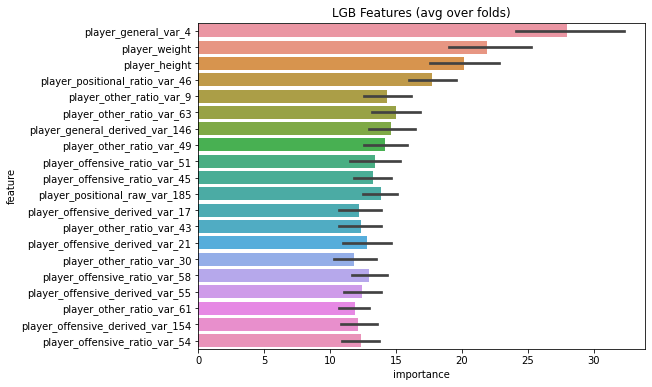

In [9]:
feature_importance["importance"] /= 10
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:20].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(8, 6))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LGB Features (avg over folds)')

In [10]:
sub['rating_num'] = test_preds

In [11]:
sub.to_csv('lgb5.csv', index = False)

In [12]:
sub

,row_id,rating_num
0,14785,7.003195
1,15125,5.111285
2,13095,5.839526
3,6079,6.330120
4,16584,6.256542
...,...,...
8769,21259,5.186171
8770,9371,8.414899
8771,23226,6.244576
8772,26623,6.546121


<AxesSubplot:>

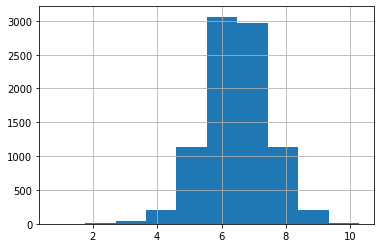

In [13]:
sub['rating_num'].hist(bins=10)

In [14]:
data['rating_num'].value_counts()

6.0     3654
6.5     3247
7.5     3206
10.0    2442
5.0     2244
7.0     1248
3.5     1077
8.5     1062
9.0     1023
8.0      873
0.0      218
3.0      110
2.0       49
Name: rating_num, dtype: int64

In [15]:
def transform(x):
    #if x < 1.0 : return 0.0
    if x > 9.5 : return 10.0 
    
    #if 4.25 < x and x < 5.25 : return 5.0
    #if 5.50 < x and x < 6.20 : return 6.0
    #if 6.40 < x and x < 6.60 : return 6.5
    #if 7.40 < x and x < 7.60 : return 7.5
    
    return x

In [16]:
sub['rating_num'] = sub['rating_num'].apply(lambda x : transform(x))

In [17]:
sub.to_csv('lgb101.csv', index = False)

<AxesSubplot:>

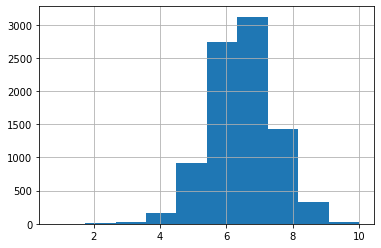

In [18]:
sub['rating_num'].hist(bins=10)

In [19]:
sub['rating_num'].min()

0.8164894083219797